## Project: Analysis of Hipparcos catalogue data

## the *Hipparcos* catalogue

*Hipparcos* (HIgh Precision PARallax COllecting Satelite) was a very important stellar survey mission between 1989 and 1993. It was the first astrometric mission of its kind, and it's precise observations allowed for unprecedented astrometrical calculations within the Milky Way. The observations of faint stars have since been (*vastly*) improved upon by the current *Gaia* mission, though the brightest stars were still most accurately observed by *Hipparcos*.

The following examples will utilise a subset of a more recent reduction of the *Hipparcos* [data](https://vizier.u-strasbg.fr/viz-bin/VizieR-3?-source=I/311/hip2) ([van Leeuwen 2007](https://arxiv.org/pdf/0708.1752.pdf)) to show how to work with astronomical data within Python, and insights into stellar populations. The dataset we use are the stars with five-parameter astrometric solutions, meaning the solutions have been constrained for RA and DEC, proper motion in RA and DEC, and parallax.

This dataset has 15 columns, with the titles as a comment in the first line. The columns (and units) are,

 - name in the *Hipparcos* catalog HIP
 - right ascentions RA ($\mathrm{RA}$; degrees)
 - error in right ascention sigma_RA ($\sigma_\mathrm{RA}$; milli-arcseconds)
 - declination DEC ($\mathrm{DEC}$; degrees)
 - error in declination sigma_DEC ($\sigma_\mathrm{DEC}$; milli-arcseconds)
 - parallax PLX ($\varpi$; in milli-arcseconds)
 - error in parallax sigma_PLX ($\sigma_\mathrm{\varpi}$; in milli-arcseconds)
 - right ascention proper motion PM_RA ($\mu_\mathrm{RA}$; milli-arcseconds per year)
 - error in right ascention proper motion sigma_PM_RA ($\sigma_{\mu, \mathrm{RA}}$; milli-arcseconds per year)
 - declination proper motion PM_DEC ($\mu_\mathrm{DEC}$; milli-arcseconds per year)
 - error in declination proper motion sigma_PM_DEC ($\sigma_{\mu, \mathrm{DEC}}$; milli-arcseconds per year)
 - *Hipparcos* magnitude Hp (dex)
   - *aka* V-band magnitude
 - error in magnitude sigma_Hp (dex)
 - B-V color (dex)
 - error in B-V color sigma_B-V (dex)
 - V-I color (dex)

### Calculating distance

A major benefit to precise astrometric observations is an accurate estimate of the parallax. This allows us to calculate the distance to each star and it reveal the structure of the Milky Way.

We begin by using the parallax ($\varpi$) to calculate the distance in parsecs (pc) to each star. It is important to remember that the parallax has units of milli-arcseconds (mas), so the distance to the star is calculated by:

$$ d = 1000 \Big(\frac{\mathrm{mas}}{\varpi}\Big) \ \mathrm{pc} $$

We can use this formula to find some interesting trends in the *Hipparcos* catalog. 

> *Note:* Each degree contains 60 arcminutes, which each contain 60 arcseconds, so there are 3 600 000 milli-arcseconds in 1 degree.

> *Note:* The Milky Way has a diameter of $\sim 40~000$ pc and Earth is located at a radius of $\sim 8~000$ pc.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from scipy import stats
from scipy.optimize import curve_fit

First, we import our data and we visualize the first 10 entries

In [78]:
data = pd.read_csv('hipparcos2.csv')
data.head(10)

,# HIP,RA,sigma_RA,DEC,sigma_DEC,PLX,sigma_PLX,PM_RA,sigma_PM_RA,PM_DEC,sigma_PM_DEC,Hp,sigma_Hp,B-V,sigma_B-V,V-I
0,HIP 1,0.000912,1.29,1.089013,0.66,4.55,1.33,-4.55,1.25,-1.19,0.75,9.2043,0.0020,0.482,0.025,0.55
1,HIP 2,0.003797,0.95,-19.498837,0.53,20.85,1.13,182.88,1.22,-1.31,0.66,9.4017,0.0017,0.999,0.002,1.04
2,HIP 3,0.005008,0.31,38.859286,0.21,2.26,0.36,4.27,0.34,-3.43,0.27,6.6081,0.0006,-0.019,0.004,0.00
3,HIP 4,0.008382,0.40,-51.893546,0.47,7.45,0.77,62.64,0.51,0.19,0.51,8.1498,0.0011,0.370,0.009,0.43
4,HIP 5,0.009965,0.55,-40.591224,0.50,3.88,0.95,1.89,0.58,8.06,0.64,8.7077,0.0018,0.902,0.013,0.90
5,HIP 6,0.018141,4.53,3.946488,2.43,18.17,5.81,225.56,6.89,-14.44,3.42,12.4488,0.0085,1.336,0.020,1.55
6,HIP 7,0.022549,0.93,20.036602,0.71,17.28,1.16,-207.90,1.04,-201.46,0.71,9.6795,0.0021,0.740,0.020,0.79
7,HIP 8,0.027292,1.72,25.886475,0.82,4.98,1.85,20.68,1.30,-6.37,0.71,8.5522,0.1671,1.102,0.051,3.92
8,HIP 9,0.035342,0.85,36.585938,0.51,2.38,0.93,-6.88,1.04,8.57,0.58,8.7534,0.0018,1.067,0.023,1.03
9,HIP 10,0.036253,0.70,-50.867074,0.68,10.83,1.00,41.80,0.91,40.82,0.78,8.6994,0.0020,0.489,0.011,0.56


Now, we want to calculate the distance in parsecs (pc) to each star using the formula:

$$
d = 1000 \Big(\frac{\mathrm{mas}}{\varpi}\Big) \ \mathrm{pc}
$$

First, we extract the information of the parallax from our data and its error.

In [3]:
plx = data['PLX']
sigma_plx = data['sigma_PLX']

Now, we calculate the distance using the formula from above

In [4]:
#distance in parsecs
d = np.multiply(1000,1/plx)

Now, in order to inspect our results, we can plot the distance that we have calculated for each single star

Text(0.5, 1.0, 'Distance to each star in pc calculated from the parallax information')

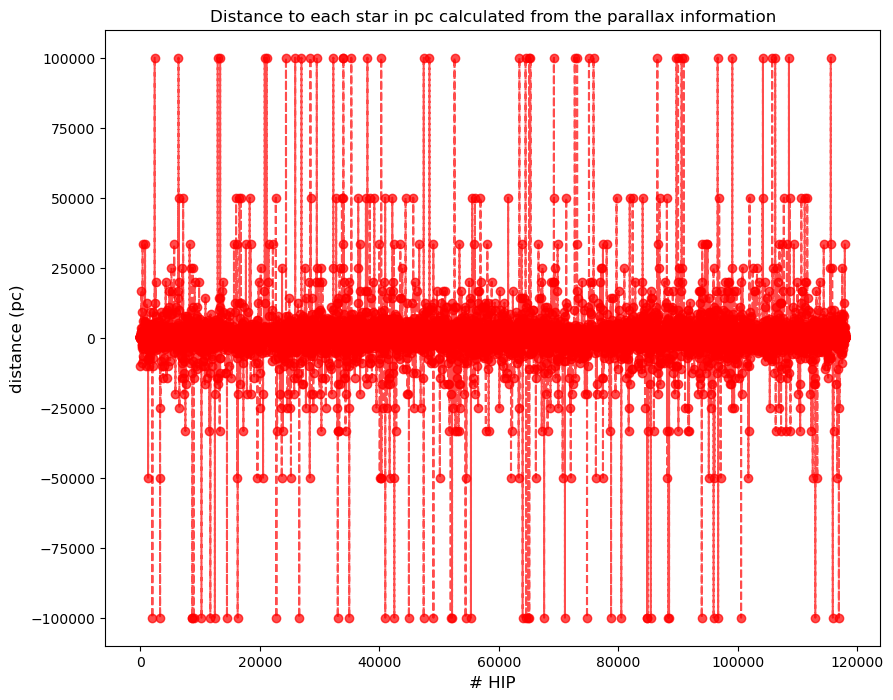

In [5]:
plt.figure(figsize=(10,8))
plt.plot(range(len(d)),d,marker='o',color='red',alpha=0.7,linestyle='--')
plt.ylabel('distance (pc)',fontsize=12)
plt.xlabel('# HIP',fontsize=12)
plt.title('Distance to each star in pc calculated from the parallax information')

From this plot we can observe several aspects, first, we have a large number of stars within our catalogue with distances between 0 and 25000 pc. The largest distance to a star founded is of around 100 kpc. However, we have a problem with the distance calculated, it can be seen that the distance to some stars is negative, and a negative distance does not have a physical meaning. In order to understand what the issue is, we can plot the data from the parallax extracted from our catalogue, otherwise, it could be a problem with our formula. We can also check if we have 'nan' or 'inf' values in our catalogue. 

First, we can check if we have 'nan' or 'inf' values in the distance to each star calculated. 

In [6]:
#Check if there is an inf value in the distance calculated and count how many times this happen
counts_inf = np.isinf(d).values.sum()
counts_nan = pd.isna(d).values.sum()
print(f"The distance series contains {counts_inf} infinite values")
print(f"The distance series contains {counts_nan} nan values")

The distance series contains 39 infinite values
The distance series contains 0 nan values


We observe that there might be a problem with the data from the catalogue or the formula, because we are obtaining 39 infinite values for the distance calculation. Now, we plot the parallax ($\varpi$) extracted from the catalogue for each single star. 

Text(0.5, 1.0, 'Parallax in milli-arcseconds for each star extracted from the HIPARCOS catalogue')

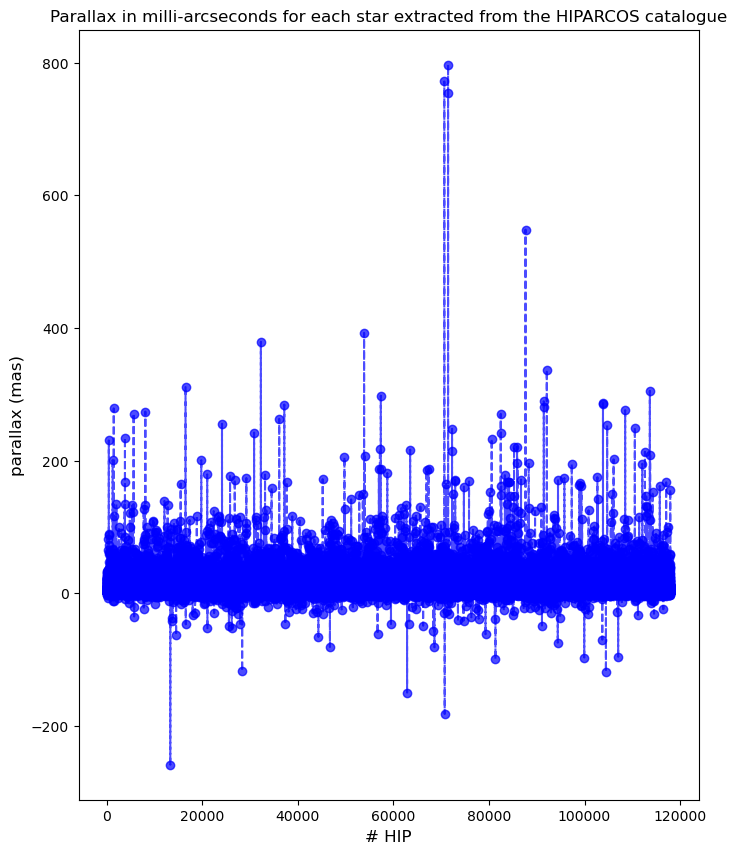

In [12]:
plt.figure(figsize=(8,10))
plt.plot(range(len(plx)),plx,marker='o',color='blue',alpha=0.7,linestyle='--')
plt.ylabel('parallax (mas)',fontsize=12)
plt.xlabel('# HIP',fontsize=12)
plt.title('Parallax in milli-arcseconds for each star extracted from the HIPARCOS catalogue')

We can also plot an histogram with the distribution of parallax

Text(0.5, 1.0, 'Parallax distribution')

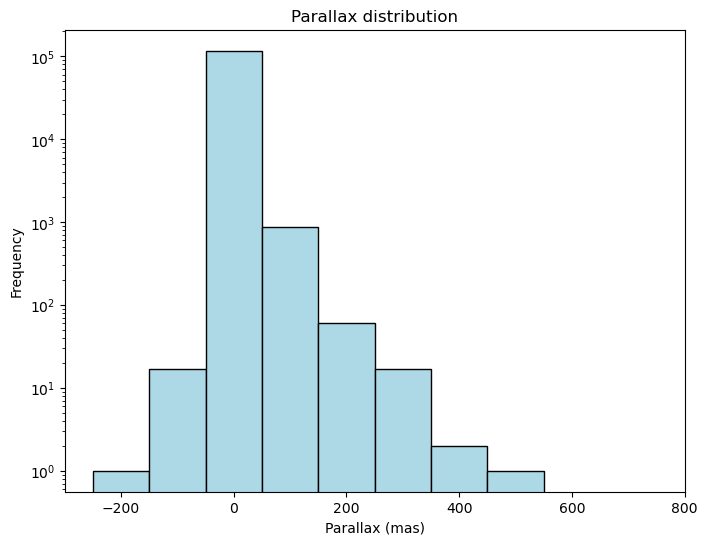

In [13]:
plt.figure(figsize=(8,6))
val,bins,_ = plt.hist(plx,bins=np.arange(-250,800,100),edgecolor='black',color='lightblue')
plt.yscale('log')
plt.ylabel('Frequency')
plt.xlabel('Parallax (mas)')
plt.title('Parallax distribution')

In [14]:
print(f"Values of the individual bins: {val}")
print(f"Bins: {bins}")

Values of the individual bins: [1.00000e+00 1.70000e+01 1.16983e+05 8.69000e+02 6.10000e+01 1.70000e+01
 2.00000e+00 1.00000e+00 0.00000e+00 0.00000e+00]
Bins: [-250. -150.  -50.   50.  150.  250.  350.  450.  550.  650.  750.]


In [15]:
#Count how many negative parallaxes are in the catalogue
count_neg = (plx<0).sum()
print(f'There are {count_neg} stars with negative parallaxes')

There are 3974 stars with negative parallaxes


From these two plots we can observe that there are stars with negative parallaxes, these values were also counted, which yielded 3974 stars with negative parallaxes. We can extract the information from negative parallaxes and their corresponding errors to check if there is a correlation between the error in parallax and the negative parallax measured. 

In [16]:
neg_plx = plx[plx<0]
sigma_neg_plx = sigma_plx[plx<0]

Text(0.5, 1.0, 'Negative Parallax in milli-arcseconds as a function of the parallax error')

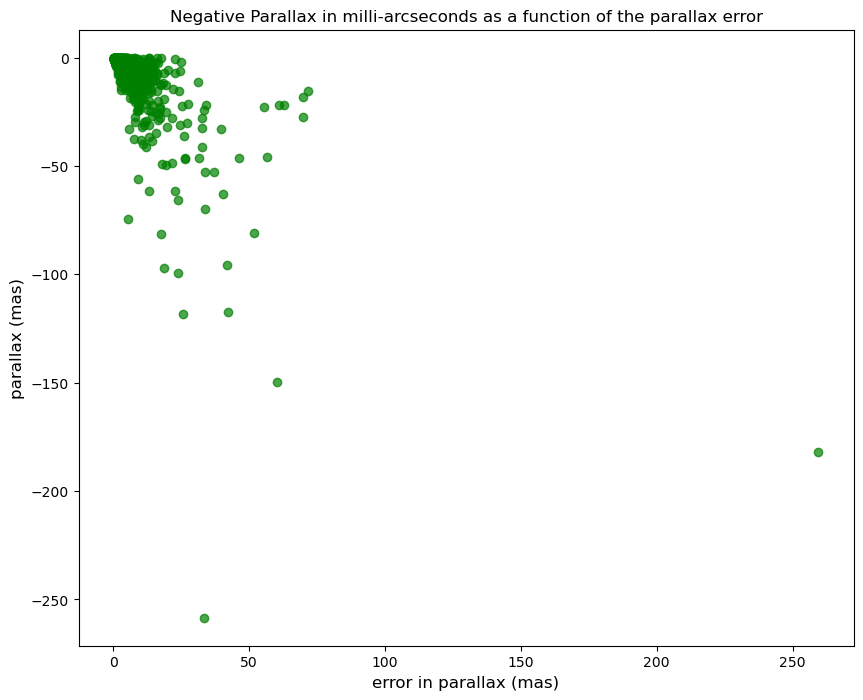

In [17]:
plt.figure(figsize=(10,8))
plt.scatter(sigma_neg_plx,neg_plx,marker='o',color='green',alpha=0.7)
plt.ylabel('parallax (mas)',fontsize=12)
plt.xlabel('error in parallax (mas)',fontsize=12)
plt.title('Negative Parallax in milli-arcseconds as a function of the parallax error')

From this figure, it can be observed that there are stars with considerably large negative values of parallax and this is related to a high error in the parallax measurement. We can also make a zoom to try to estimate the range of errors where we can find most of the stars with nevative values of parallax. 

(-15.0, 0.5)

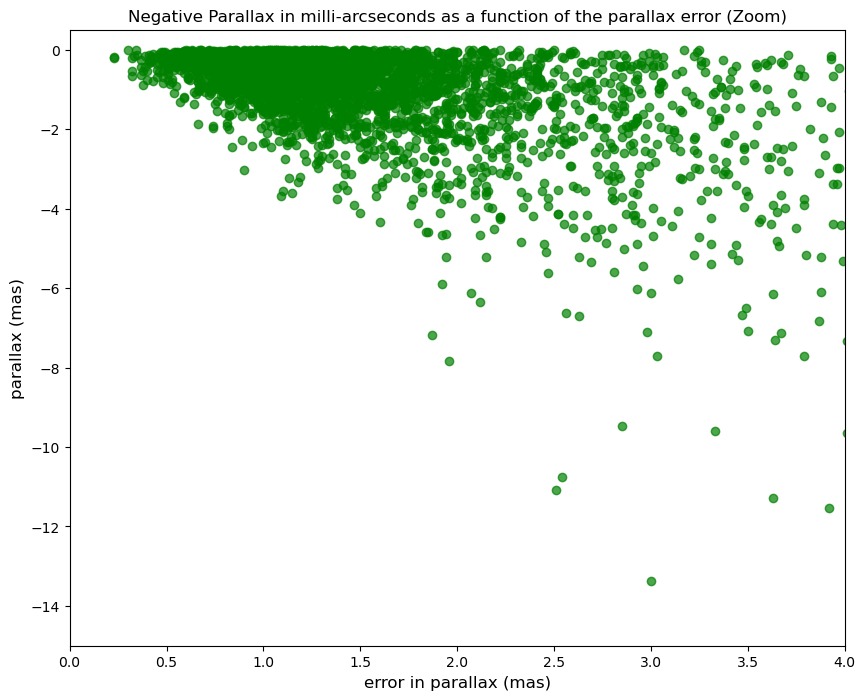

In [18]:
plt.figure(figsize=(10,8))
plt.scatter(sigma_neg_plx,neg_plx,marker='o',color='green',alpha=0.7)
plt.ylabel('parallax (mas)',fontsize=12)
plt.xlabel('error in parallax (mas)',fontsize=12)
plt.title('Negative Parallax in milli-arcseconds as a function of the parallax error (Zoom)')
plt.xlim([0,4])
plt.ylim([-15,0.5])

It can be observed that most of the stars with negative values of parallax have errors from 0.23 to around 0.39 mas. So, the negative parallax could in principle be due to measurement errors where the closer star was placed as the far star. 

Based on this previous analysis, we could ignore the values of parallax considerably small to avoid infinite values 
in the distance calculation and to avoid or ignore the negative values of parallax, although, this negative parallax can be interpreted as 'stars going in the wrong way', this means, taking them as the nearer star when they actually correspond to the far star.  We are going to calculate the distance using only positive values of the parallax from the catalogue. 

In [19]:
corr_dist = np.multiply(1000,plx[plx>=0])#new distance using positive values of plx
#we check if there are inf values
counts_inf2 = np.isinf(corr_dist).values.sum()
print(f'There are {counts_inf2} infinite values')

There are 0 infinite values


Now, we can plot an histogram with the new distances in parsecs calculated

Text(0.5, 1.0, 'Distribution of distance in pc calculated using only positive values of plx')

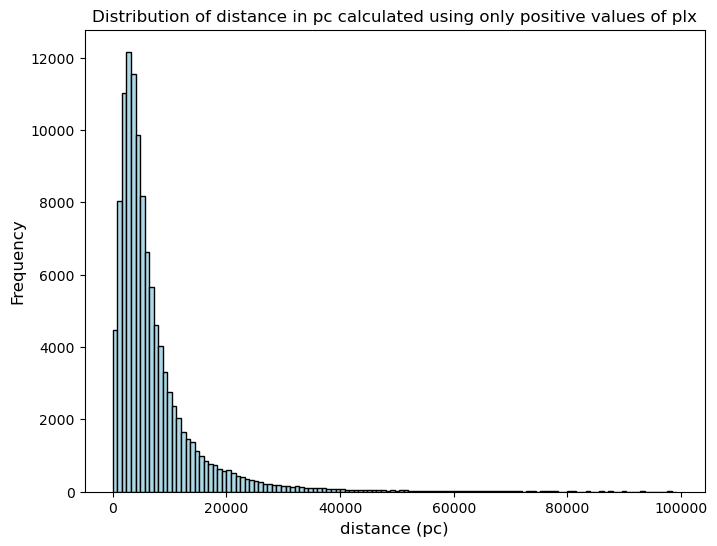

In [20]:
plt.figure(figsize=(8,6))
val,bins,_ = plt.hist(corr_dist,bins=np.arange(0,100000,800),edgecolor='black',color='lightblue')
plt.xlabel('distance (pc)', fontsize=12)
plt.ylabel('Frequency',fontsize=12)
plt.title('Distribution of distance in pc calculated using only positive values of plx')

From the figure, it can be observed that the distance to each star in parsecs follows a right tailed distribution,
and that there is no negative distance calculated this time.

## Finding the most common distance to a star


The most common distance to a star corresponds to the value of distance $d_i$ ocurrying most frequently,i.e, the mode. We will write a simple function using the $\mathrm{Counter}$ routine to find the mode from our distance set.  

In [21]:
from collections import Counter

def my_mode(sample):
    c = Counter(sample)
    return [k for k, v in c.items() if v == c.most_common(1)[0][1]]

In [25]:
com_distance = my_mode(corr_dist)
print(f"The most common distance to  star corresponds to {com_distance[0]} pc")

The most common distance to  star corresponds to 2880.0 pc


We can find the standard deviation of this value with the formula:

$$
\sigma = (x_i-\bar{x})
$$

where $\bar{x}$ corresponds to the mean distance.

In [27]:
mean_distance = np.mean(corr_dist)
sigma = np.abs(com_distance[0]-mean_distance)

print(f"The standard deviation is {sigma} pc")

The standard deviation is 4665.670243286162 pc


From these values we can estimate one statistic of location, which is the mode and the scatter from this value to the mean value, to have a description of the data. We observe that the dispersion from the average of the most common distance to a star is 4665.67 pc.

### Utilising error

Error is a major aspect of observational data, since there are so many sources (instrumentational and physical) to consider. Following the procedure of van Leeuwen (2007), let us examine the error in parallax and its trends in our dataset. Relative error $\big(\frac{\sigma_q}{q}\big)$ is an important metric when our data spans multiple orders of magnitude. 

First, we calculate the relative error $\big(\frac{\sigma_q}{q}\big)$ using the parallax and the error in parallax extracted before, we should exclude the values where the parallax is zero to avoid singularities.  

In [28]:
rerr_plx = np.divide(sigma_plx[plx!=0], plx[plx!=0])

And in order to observe the distribution of relative error in parallax we can plot an histogram

Text(0.5, 1.0, 'Distribution of relative error in parallax')

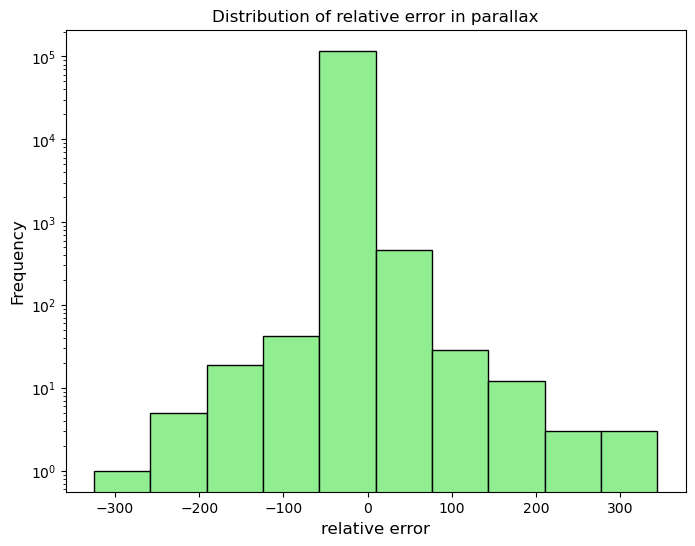

In [29]:
plt.figure(figsize=(8,6))
val,bins,_ = plt.hist(rerr_plx,edgecolor='black',color='lightgreen')
plt.xlabel('relative error', fontsize=12)
plt.ylabel('Frequency',fontsize=12)
plt.yscale('log')
plt.title('Distribution of relative error in parallax')

In [30]:
print(val)
print(bins)

[1.00000e+00 5.00000e+00 1.90000e+01 4.20000e+01 1.17336e+05 4.66000e+02
 2.90000e+01 1.20000e+01 3.00000e+00 3.00000e+00]
[-325.  -258.1 -191.2 -124.3  -57.4    9.5   76.4  143.3  210.2  277.1
  344. ]


From the figure, the advantage of using the relative error as a metric can be appreciated since as shown by the graph, the data spans several orders of magnitude. The results obtained imply that most of the data obtained by $\textit{Hipparcos'}$ (around $10^5$) has relative errors in parallax between 9.5 and 76.4 (for positive relative errors). We can estimate the standard deviation of the relative error in parallax to have an estimation of the precision of $\textit{Hipparcos'}$, since the precision measures how dispersed the observations are to each other. 

In [31]:
import statistics

#standard deviation of relative error
sd_rerr = statistics.stdev(rerr_plx)
print(f"The standard deviation of the relative error in parallax is: {sd_rerr}")

The standard deviation of the relative error in parallax is: 4.953530512794037


The standard deviation found for the relative error could indicate that the $\textit{Hipparcos'}$ data has a precision of around 4.95.

The error in parallax is typically related to the brightness of the star (from the statistics of photon counts). A view of this trend can be seen below (keeping the relative parallax error below 5%; similar to Figure 11 in van Leewen 2007). 

Now, we can filter our data by taking only those values where the relative parallax error is below $5\%$. To do this, we first extract the information from our catalogue where the parallax is different from zero (to match relative error parallax array) and where the relative parallax error is positive. Then, we perform masking to find the array where the relative error is positive. The new catalogue is created by performing masking with the condition of a relative error below $5\%$. Once the catalogue with the filtered information is created, the data needed for the plot can be extracted. 

In [32]:
data_pos5 = data[plx!=0][rerr_plx>0] 
pos_rerr5 = rerr_plx[rerr_plx>0]
data_filtered5 = data_pos5[pos_rerr5<0.05]
data_filtered5.head()

,# HIP,RA,sigma_RA,DEC,sigma_DEC,PLX,sigma_PLX,PM_RA,sigma_PM_RA,PM_DEC,sigma_PM_DEC,Hp,sigma_Hp,B-V,sigma_B-V,V-I
33,HIP 34,0.099470,0.48,26.918238,0.30,13.40,0.57,42.43,0.48,-53.29,0.30,6.5466,0.0009,0.514,0.005,0.59
37,HIP 38,0.111047,0.54,-79.061831,0.58,23.64,0.66,163.54,0.65,-62.97,0.55,8.7854,0.0019,0.778,0.015,0.81
42,HIP 43,0.129089,0.27,59.559738,0.25,7.34,0.35,-80.81,0.37,-23.64,0.28,6.3456,0.0006,1.032,0.005,1.00
49,HIP 50,0.142870,0.26,-53.097663,0.30,16.83,0.51,52.93,0.34,-20.91,0.34,6.6231,0.0006,0.616,0.005,0.68
54,HIP 55,0.157834,0.52,-66.683103,0.57,15.40,0.69,162.84,0.56,-28.91,0.63,7.5159,0.0010,0.551,0.015,0.62


In [33]:
#we extract the information
mag_Hp5 = data_filtered5["Hp"]
sigma_plx5 = data_filtered5["sigma_PLX"]

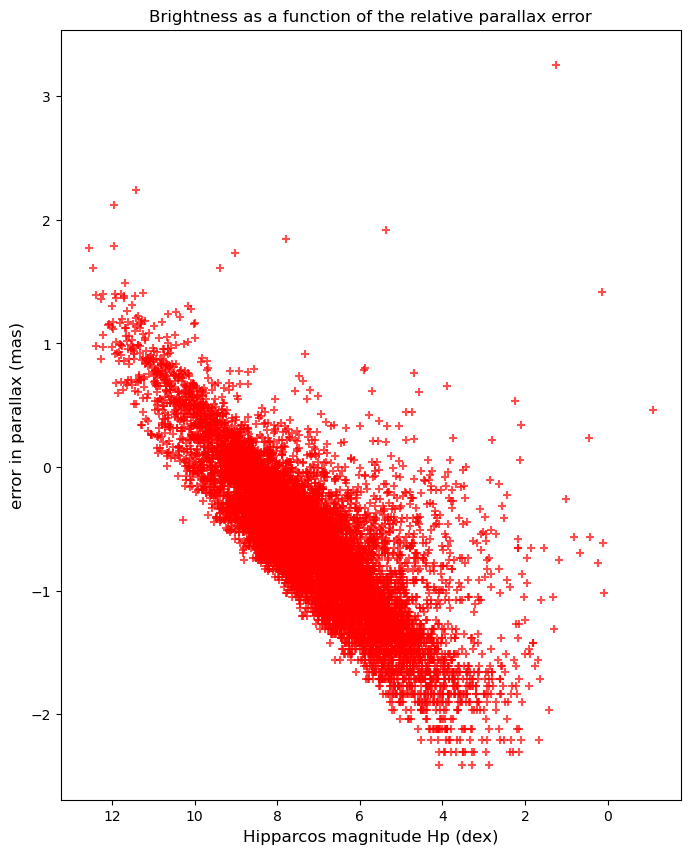

In [34]:
fig, axs = plt.subplots(figsize=(8,10))
axs.scatter(mag_Hp5,np.log(sigma_plx5),marker='+',color='red',alpha=0.7)
axs.set_xlabel('Hipparcos magnitude Hp (dex)',fontsize=12)
axs.set_ylabel('error in parallax (mas)',fontsize=12)
axs.set_title('Brightness as a function of the relative parallax error')
axs.invert_xaxis()

It can be seen from the figure that there is a linear trend between the brightness of the star and the relative error in parallax. This plot is similar to Figure 11 in van Leewen 2007, however, there are more points out of the linear trend, contrary to Figure 11, where the points within the trend are almost isolated. We can find a linear fit to this relation using the $\mathrm{curve\_fit}$ routine from Python. 

In [35]:
def f_linear(x,m,b):
    return m*x+b

In [36]:
popt, pcov = curve_fit(f_linear,mag_Hp5, np.log(sigma_plx5))#do the fit
print(f"The optimal parameteres are: {popt}, where m={popt[0]} (mas/dex) and b={popt[1]} (mas)") 

The optimal parameteres are: [ 0.28726367 -2.67692283], where m=0.28726367333417935 (mas/dex) and b=-2.6769228342748383 (mas)


In [37]:
sigma_m = np.sqrt(pcov[0,0]) #uncertainty in the slope
sigma_b = np.sqrt(pcov[1,1]) #uncertainty in the intercept
print(f"The uncertainties in the slope and the intercept are: {sigma_m,sigma_b}")

The uncertainties in the slope and the intercept are: (0.001918270129772598, 0.01387329417555353)


We found a linear fit to the relation of the form:
$$
y=mx+b
$$
where $\mathrm{m}$ is the slope and $\mathrm{b}$ is the intercept,here we considered $y=log(\sigma_{\text{PLX}})$. We found the parameters:

$$m = (0.287\pm0.002) $$ and $$b=(-2.677\pm0.014) $$

With this we can find the exponential relation:
$$
log(\sigma_{PLX})=-2.67+0.28Hp
$$
and this leads to the relation:
$$
\sigma_{PLX}=e^{-2.67+0.28Hp}\approx0.07e^{0.28Hp}
$$

## Distribution of relative errors in $\mathrm{RA}, \ \mathrm{DEC},$ and $\mathrm{PLX}$


Given that in this case, there are no zero values for $\mathrm{RA}$ and $\mathrm{DEC}$ we can calculate the relative errors without ignoring some values.

In [38]:
rerr_ra = np.divide(data['sigma_RA'],data['RA'])#relative error RA
rerr_dec = np.divide(data['sigma_DEC'],data['DEC']) #relative error DEC

Text(0.5, 1.0, 'Distribution of relative error in parallax')

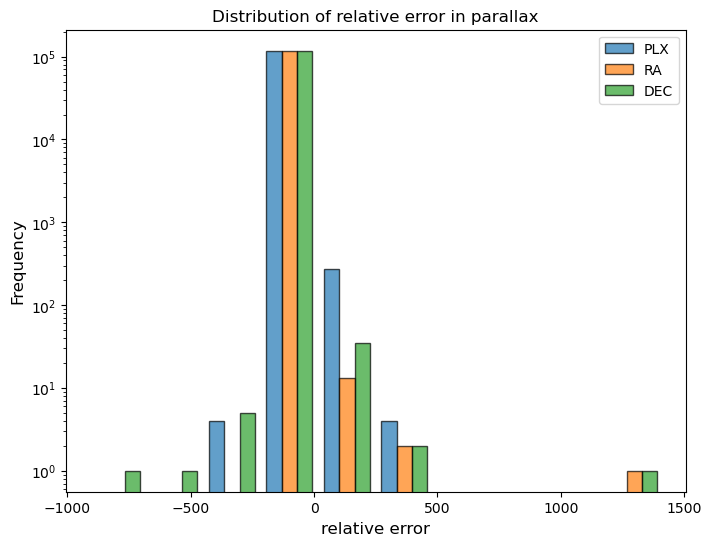

In [39]:
plt.figure(figsize=(8,6))
plt.hist([rerr_plx,rerr_ra,rerr_dec],label=['PLX','RA','DEC'],edgecolor='black',alpha=0.7)
plt.xlabel('relative error', fontsize=12)
plt.ylabel('Frequency',fontsize=12)
plt.yscale('log')
plt.legend()
plt.title('Distribution of relative error in parallax')

It can be seen from the histogram that the realtive error in $\mathrm{DEC}$ also spans negative values as in the plx relative error. The distribution is nearly exponential in the three cases if we exclude the negative relative errors for $\mathrm{PLX}$ and $\mathrm{DEC}$. There is a large number of stars with small relative errors (between around 20 and 200).

### Hertzsprung-Russell diagrams

#### Observational

Before calculating any intrinsic stellar properties from the observations, it is typically useful to plot a diagram of what we *observe*. (Observed here means the most basic properties that can be determined from the data. If we want to be pedantic, then we might suggest that the values in this table are not what is actually observed, but a reduction of the observed photon counts.) For this purpose we should plot a Hertzsprung-Russel diagram (HRD) to reveal the different stellar types. It is important not only to remember that a HRD has colour (B-V) on the x-axis and magnitude (Hp) on the y-axis, but also that the y-axis is reversed (the perks of using an antiquated unit).

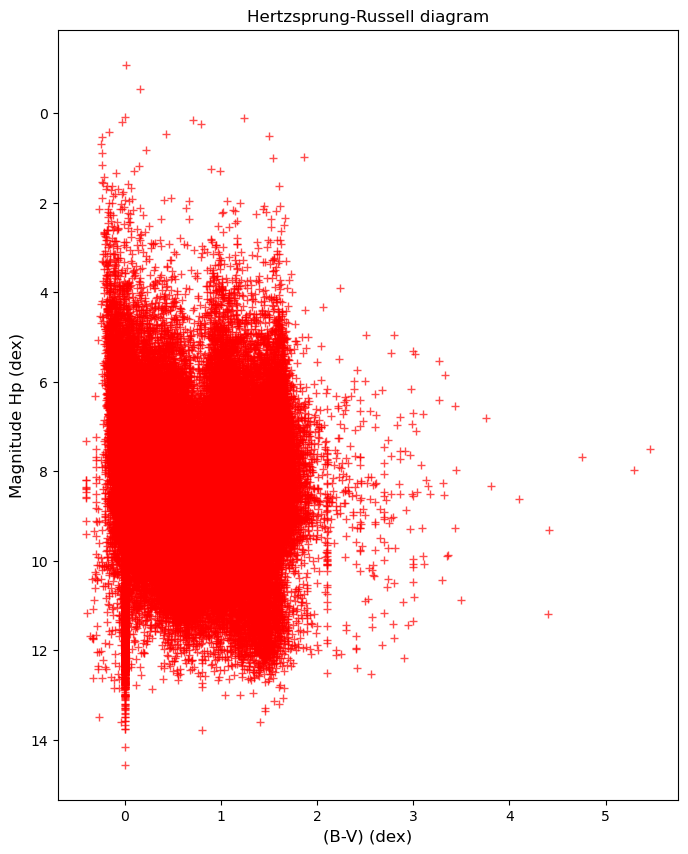

In [40]:
fig, axs = plt.subplots(figsize=(8,10))
axs.scatter(data['B-V'],data['Hp'],marker='+',color='red',alpha=0.7,linewidths=1)
axs.set_ylabel('Magnitude Hp (dex)',fontsize=12)
axs.set_xlabel('(B-V) (dex)',fontsize=12)
axs.set_title('Hertzsprung-Russell diagram')
axs.invert_yaxis()

From the figure, it is difficult to observe the main features of an HR diagram, there is also a large density of points in various regions of the plot.



Since we are using the magnitude given in `hipparcos2.csv`, we have a little difficulty determining the different regions of an HR diagram. One reason for this is that it is an apparent magnitude, so these results do not take into account reddening or extinction. Another issue, however, is that we don't filter the results that have a lot of error. We can try plotting it again while limiting the relative parallax error to <20% and the color error to 5 mag. 

Here we follow a similar approach as the one employed before to filter the catalogue and include only data where the relative parallax error is $<20\%$ and the color error to 5 mag. First, we mask our data to select only data with parallax different from zero and positive relative parallax error, then we mask our relative parallax error array to select only positive values. Then, the catalogue where the relative parallax error is below $20\%$ is extracted. And finally, we filter our catalogue limiting the color error to 5 mag. Since the units of magnitude are in dex, we impose the condition $\sigma_{\text{B-V}}<\log_{10}(5)=0.7$   

In [41]:
#First we filter all our data limiting the relative parallax error to <20%
data_new = data[plx!=0][rerr_plx>0]
positive_error_plx = rerr_plx[rerr_plx>0]#here I took out the value with plx!=0
data_filtered = data_new[positive_error_plx<0.2]
#Now we filter by taking the color error to 5mag
data_filteredbycolor = data_filtered[data_filtered['sigma_B-V']<0.7]
data_filteredbycolor.head()

,# HIP,RA,sigma_RA,DEC,sigma_DEC,PLX,sigma_PLX,PM_RA,sigma_PM_RA,PM_DEC,sigma_PM_DEC,Hp,sigma_Hp,B-V,sigma_B-V,V-I
1,HIP 2,0.003797,0.95,-19.498837,0.53,20.85,1.13,182.88,1.22,-1.31,0.66,9.4017,0.0017,0.999,0.002,1.04
2,HIP 3,0.005008,0.31,38.859286,0.21,2.26,0.36,4.27,0.34,-3.43,0.27,6.6081,0.0006,-0.019,0.004,0.00
3,HIP 4,0.008382,0.40,-51.893546,0.47,7.45,0.77,62.64,0.51,0.19,0.51,8.1498,0.0011,0.370,0.009,0.43
6,HIP 7,0.022549,0.93,20.036602,0.71,17.28,1.16,-207.90,1.04,-201.46,0.71,9.6795,0.0021,0.740,0.020,0.79
9,HIP 10,0.036253,0.70,-50.867074,0.68,10.83,1.00,41.80,0.91,40.82,0.78,8.6994,0.0020,0.489,0.011,0.56


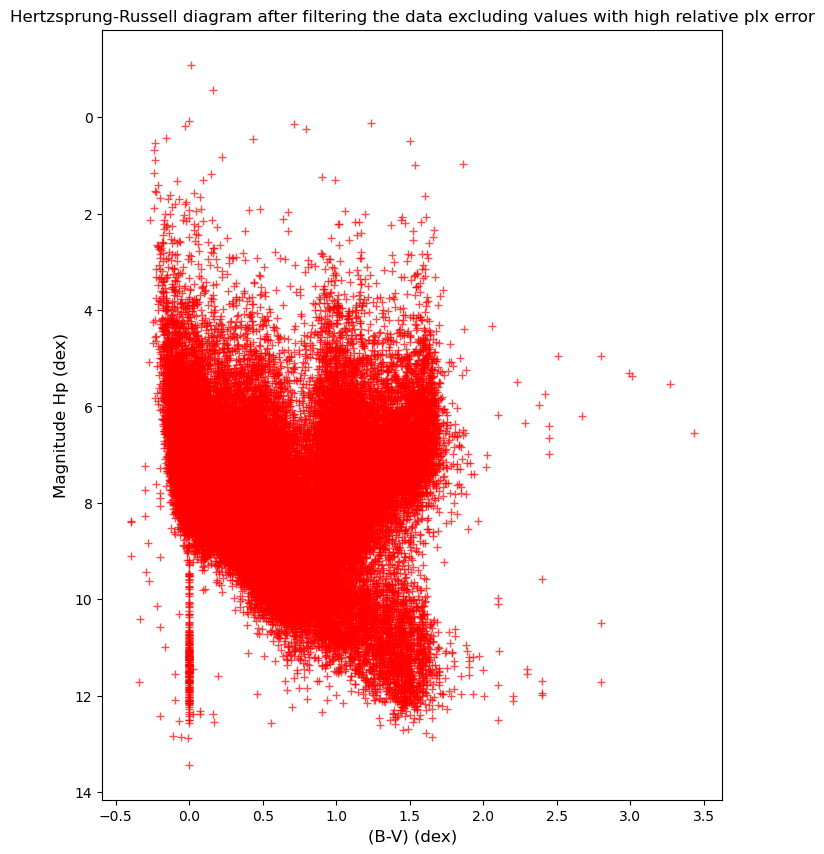

In [42]:
fig, axs = plt.subplots(figsize=(8,10))
axs.scatter(data_filteredbycolor['B-V'],data_filteredbycolor['Hp'],marker='+',color='red',alpha=0.7,linewidths=1)
axs.set_ylabel('Magnitude Hp (dex)',fontsize=12)
axs.set_xlabel('(B-V) (dex)',fontsize=12)
axs.set_title('Hertzsprung-Russell diagram after filtering the data excluding values with high relative plx error')
axs.invert_yaxis()

It can be seen that by comparison with the last HR diagram, the features are more distinguishable in this case, where we have excluded values with high relative parallax error. 

One trait now looks more prominent, and that is the suspiciously high number of stars with $ B-V = 0 $. This is called an artefact, and it is a result of some bad data or sloppy reduction. Since the author of this reduction is quite renowned in the community, the issue most likely lies with bad data for these stars. For the rest of the exercise, you may filter-out star with $B-V = 0$.

Here, we are extracting the catalogue information (froum our filtered by color catalogue) where $B-V$ is different from zero.

In [43]:
data_filteredbyB_V = data_filteredbycolor[data_filteredbycolor['B-V']!=0]

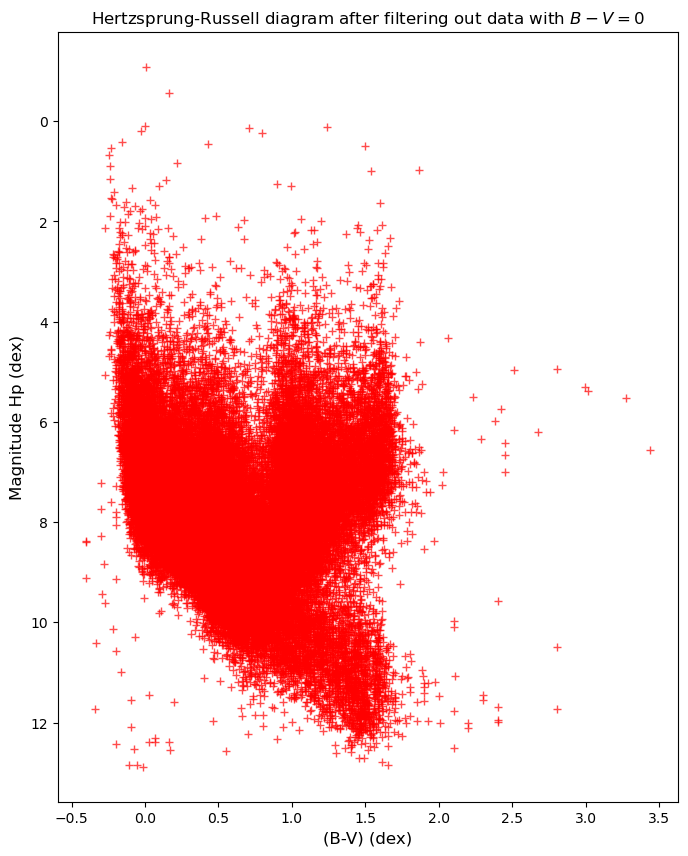

In [44]:
fig, axs = plt.subplots(figsize=(8,10))
axs.scatter(data_filteredbyB_V['B-V'],data_filteredbyB_V['Hp'],marker='+',color='red',alpha=0.7,linewidths=1)
axs.set_ylabel('Magnitude Hp (dex)',fontsize=12)
axs.set_xlabel('(B-V) (dex)',fontsize=12)
axs.set_title('Hertzsprung-Russell diagram after filtering out data with $B-V=0$')
axs.invert_yaxis()

In this case, we can notice that the long vertical strip has been removed after filtering out the data where $B-V=0$.



Now we can try plotting the HRD in terms of the intrinsic absolute magnitude, $ M_{Hp} $ (we should get something similar in shape to [this](https://www.cosmos.esa.int/documents/532822/573165/f3_5_005.pdf/90951100-6586-4ba7-a042-784f5845a279)). We could also try with the other colour $V-I$. The absolute magnitude can be calculated by the formula:

$$
M_\mathrm{Hp} = m_\mathrm{Hp} - 5 \ \mathrm{log}_\mathrm{10}\Big(\frac{d}{pc}\Big) + 5
$$



First, we define our absolute magnitude with the formula given above

In [45]:
def f_abs_mag(m_Hp,d_pc):
    M_Hp = m_Hp-5*np.log10(d_pc)+5
    return M_Hp

In [46]:
app_mag_Hp = data_filteredbyB_V['Hp']# apparent magnitude 
distance_new = np.divide(1000,data_filteredbyB_V['PLX']) #distance in pc from the filtered by color catalogue

In [47]:
abs_mag_Hp = f_abs_mag(app_mag_Hp,distance_new)#we calculate the absolute magnitude

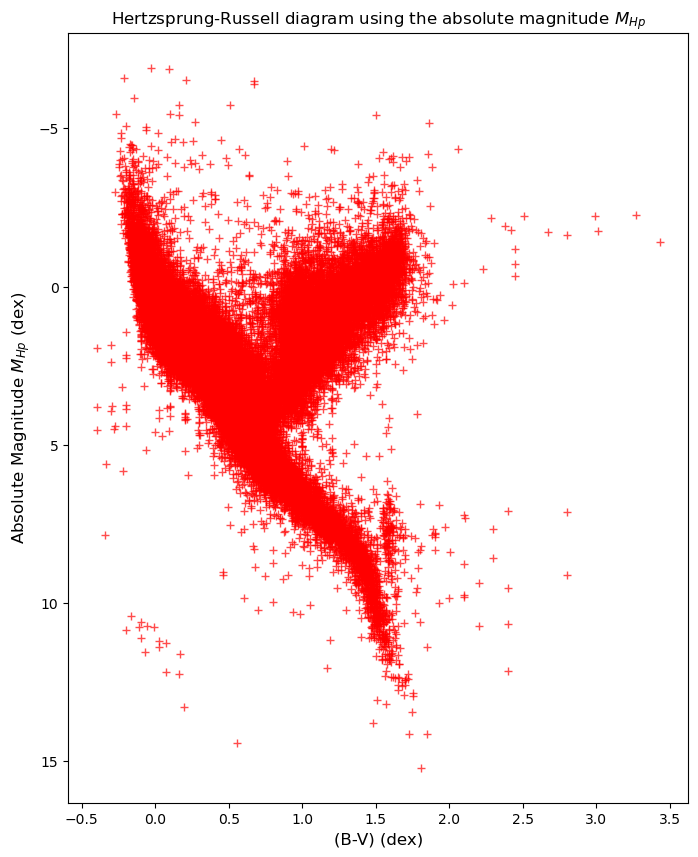

In [48]:
fig, axs = plt.subplots(figsize=(8,10))
axs.scatter(data_filteredbyB_V['B-V'],abs_mag_Hp,marker='+',color='red',alpha=0.7,linewidths=1)
axs.set_ylabel(r'Absolute Magnitude $M_{Hp}$ (dex)',fontsize=12)
axs.set_xlabel('(B-V) (dex)',fontsize=12)
axs.set_title(r'Hertzsprung-Russell diagram using the absolute magnitude $M_{Hp}$')
axs.invert_yaxis()

It can be seen that with this plot the regions of the HR diagram can be easily identified, however, there are still many points on top of each other, so it would be convenient to plot the number density of points in a 2d histogram. Now, we follow a similar approach but this time using the data from the color index $V-I$.

In [49]:
data_filteredbyV_I = data_filteredbycolor[data_filteredbycolor['V-I']!=0]

In [50]:
app_mag_HpVI = data_filteredbyV_I['Hp']
distance_VI = np.divide(1000,data_filteredbyV_I['PLX'])
abs_mag_HpVI = f_abs_mag(app_mag_HpVI,distance_VI)

(-1.0, 6.0)

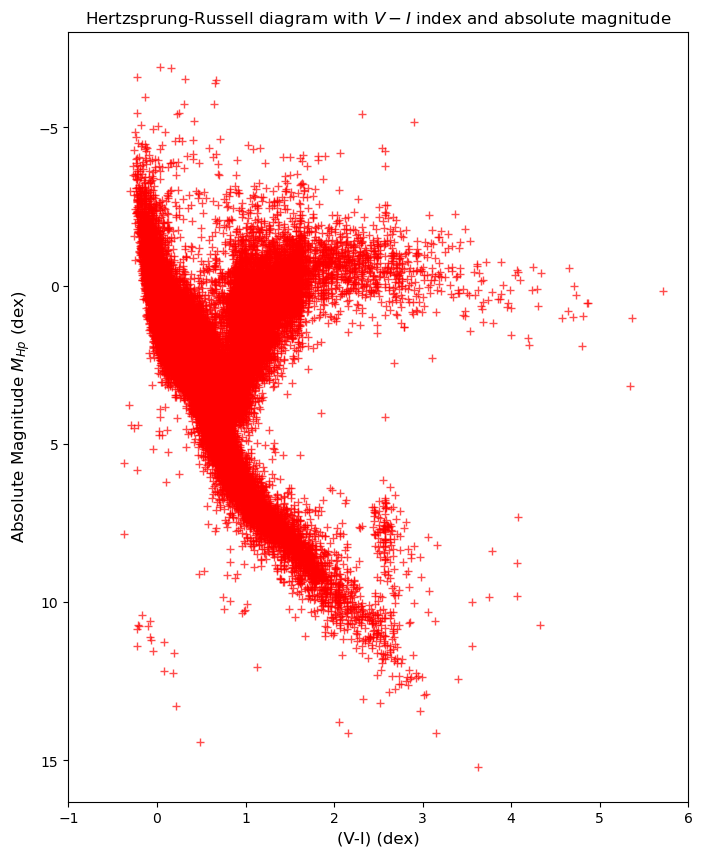

In [51]:
fig, axs = plt.subplots(figsize=(8,10))
axs.scatter(data_filteredbyV_I['V-I'],abs_mag_HpVI,marker='+',color='red',alpha=0.7,linewidths=1)
axs.set_ylabel(r'Absolute Magnitude $M_{Hp}$ (dex)',fontsize=12)
axs.set_xlabel('(V-I) (dex)',fontsize=12)
axs.set_title(r'Hertzsprung-Russell diagram with $V-I$ index and absolute magnitude')
axs.invert_yaxis()
axs.set_xlim([-1,6])

**Plot the number density**

Here, we use the function  `scipy.stats.binned_statistic_2d()`, and we are binning the data in steps of 0.05 mag in $M_{Hp}$ and 0.01 mag in $B-V$, with the number density in the color bar. 

In [52]:
from scipy import stats

In [53]:
binx = np.arange(np.min(data_filteredbyB_V['B-V']),np.max(data_filteredbyB_V['B-V']),0.01)
biny = np.arange(np.min(abs_mag_Hp),np.max(abs_mag_Hp),0.05)
#counts in a 2d histogram
binned_stat = stats.binned_statistic_2d(data_filteredbyB_V['B-V'],abs_mag_Hp, None,'count', bins=[binx,biny])

To construct the histogram we use the $\mathrm{hexbin}$ routine but also the $\mathrm{plt.hist2d}$ because it is easier to see the number density with the latter.

Text(0.5, 1.0, 'Hertzsprung-Russell diagram number density of points')

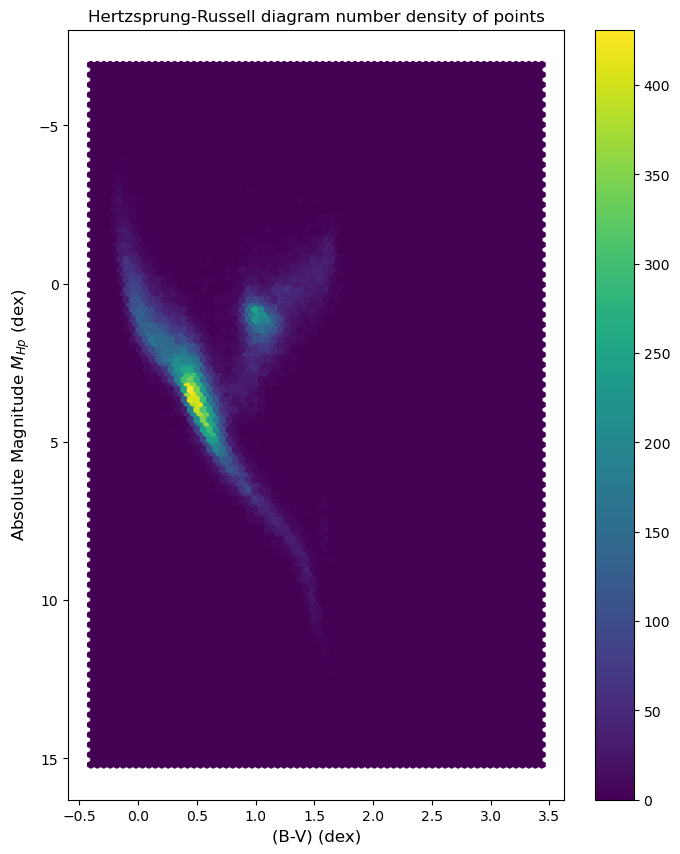

In [54]:
fig, axs = plt.subplots(figsize=(8,10))
hb = axs.hexbin(data_filteredbyB_V['B-V'],abs_mag_Hp, gridsize=(70,70))
axs.invert_yaxis()
cb = fig.colorbar(hb, ax=axs)
axs.set_ylabel(r'Absolute Magnitude $M_{Hp}$ (dex)',fontsize=12)
axs.set_xlabel('(B-V) (dex)',fontsize=12)
axs.set_title(r'Hertzsprung-Russell diagram number density of points')

Text(0.5, 1.0, 'Hertzsprung-Russell diagram number density of points')

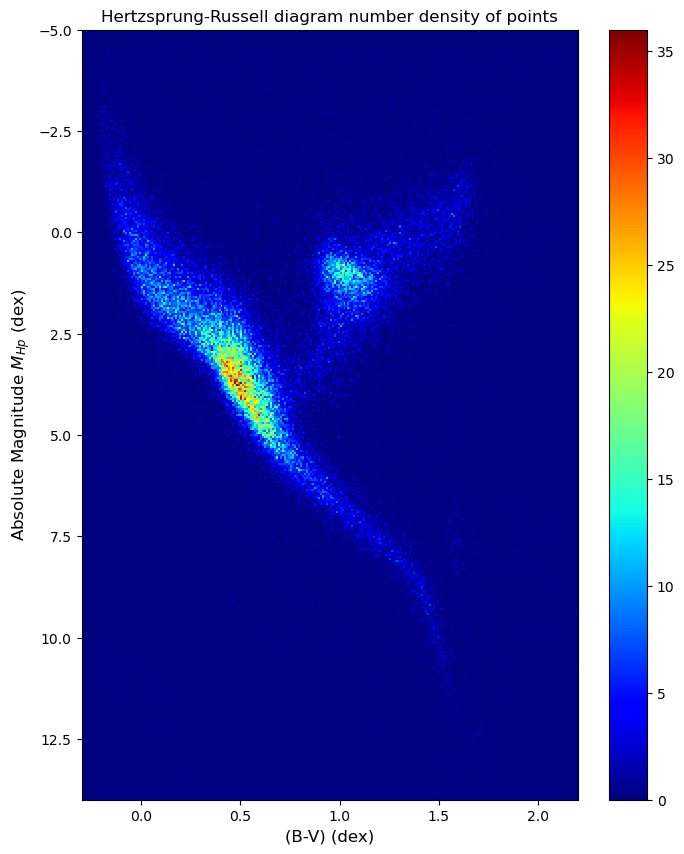

In [55]:
fig, axs = plt.subplots(figsize=(8,10))
h=axs.hist2d(data_filteredbyB_V['B-V'],abs_mag_Hp, bins=[binx,biny], cmap=plt.cm.jet)
axs.invert_yaxis()
fig.colorbar(h[3],ax=axs)
#cb=fig.colorbar(hb)
axs.set_xlim([-0.3,2.2])
axs.set_ylim([14,-5.0])
axs.set_ylabel(r'Absolute Magnitude $M_{Hp}$ (dex)',fontsize=12)
axs.set_xlabel('(B-V) (dex)',fontsize=12)
axs.set_title(r'Hertzsprung-Russell diagram number density of points')

Very broadly we say that the features observed here are the main sequence (diagonal feature) and red clump (roughly spherical feature).

We will try to isolate the main sequence in order to fit a line here, to do this, we first extract all data with color index $(B-V)<1.5$, then from this new catalogue we extract the apparent magnitude and we calculate the absolute magnitude as was done previously.

In [56]:
catalogue_isolate = data_filteredbyB_V[data_filteredbyB_V["B-V"]<1.5]
app_mag_isolate = catalogue_isolate['Hp']
distance_isolate = np.divide(1000,catalogue_isolate['PLX'])
abs_mag_isolate = f_abs_mag(app_mag_isolate,distance_isolate)

Now, we are going to use the zip function to create a list of tuples with the value for the color index $B-V$ in the x-coordinate and the one for the absolute magnitude in the y-coordinate.

In [57]:
points = list(zip(catalogue_isolate["B-V"],abs_mag_isolate))

Now, we construct a function in order to remove all data points from the red clump (approximately) and isolate the main sequence (the function is a bit slow)

In [58]:
def isolate_ms(data):
    m_list=[]
    for i in range(len(data)):
        if (data[i][0]>0.75):
            if (data[i][1]<4):
                m_list.append(data[i])
    data_new = [j for j in data if j not in m_list]
            #m=(data[i+1][1]-data[i][1])/(data[i+1][0]-data[i][0])
            #if m>50:
                #m_list.append(data[i])
    return data_new         

In [59]:
points_ms = isolate_ms(points) #points in the Main Sequence

In [60]:
B_V_MS,abs_mag_MS = zip(*points_ms)

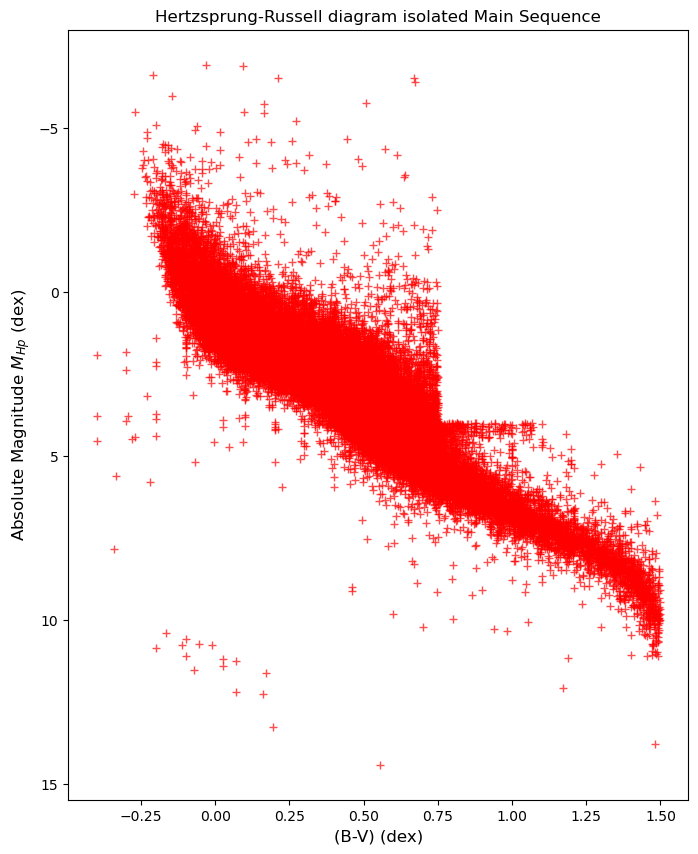

In [61]:
fig, axs = plt.subplots(figsize=(8,10))
axs.scatter(B_V_MS,abs_mag_MS,marker='+',color='red',alpha=0.7,linewidths=1)
axs.set_ylabel(r'Absolute Magnitude $M_{Hp}$ (dex)',fontsize=12)
axs.set_xlabel('(B-V) (dex)',fontsize=12)
axs.set_title('Hertzsprung-Russell diagram isolated Main Sequence')
axs.invert_yaxis()

From the graph, it can be seen that not all the points in the red clump were perfectly removed but the diagonal feature in the HR diagram can be easily observed. Now, a linear fit of the data within the MS can be applied. 

In [62]:
#linear fit 
popt_MS, pcov_MS = curve_fit(f_linear,B_V_MS, abs_mag_MS)#do the fit
print(f"The optimal parameteres are: {popt_MS}, where m={popt_MS[0]}  and b={popt_MS[1]}") 

The optimal parameteres are: [6.04857351 0.38603775], where m=6.048573512430108  and b=0.38603775290279374


In [63]:
#uncertainties
sigma_m_MS = np.sqrt(pcov_MS[0,0]) #uncertainty in the slope
sigma_b_MS = np.sqrt(pcov_MS[1,1]) #uncertainty in the intercept
print(f"The uncertainties in the slope and the intercept are: {sigma_m_MS,sigma_b_MS}")

The uncertainties in the slope and the intercept are: (0.013936980651200182, 0.007701315579963464)


In [64]:
print("Number of stars isolated in the Main Sequence:", len(B_V_MS))
print("Total number of stars before removing stars in the red clump",len(points))

Number of stars isolated in the Main Sequence: 44552
Total number of stars before removing stars in the red clump 57992


We found a linear fit of the form:
$$
M_{Hp} = (6.048\pm0.014)(B-V)+(0.386\pm0.007)
$$


In order to approximate the percentage of stars in the Main Sequence with respect to the stars in the red clump, we know that we isolated 44552 stars in the main sequence in our approach from a total of 57992, so there are around 13440 stars in the red clump. And we could try to estimate this percentage as $(44552/13440)*100\approx331.5\%$. 

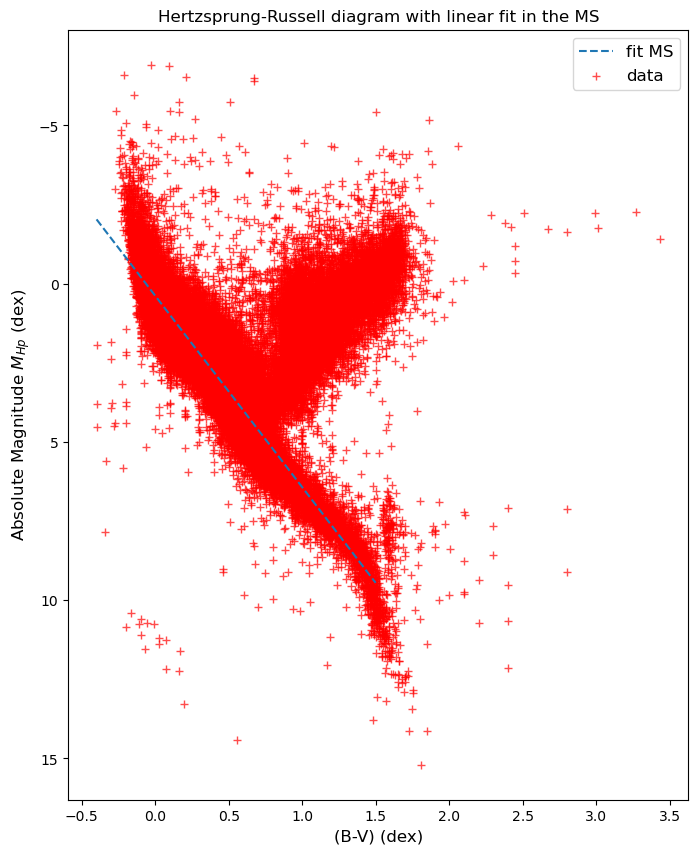

In [65]:
#HR diagram with the linear fit
x_fit = np.linspace(np.min(B_V_MS),np.max(B_V_MS),len(B_V_MS))
y_fit = 6.048*x_fit+0.386

fig, axs = plt.subplots(figsize=(8,10))
axs.plot(x_fit,y_fit,label='fit MS',linestyle="--")
axs.scatter(data_filteredbyB_V['B-V'],abs_mag_Hp,marker='+',color='red',alpha=0.7,linewidths=1,label='data')
axs.set_ylabel(r'Absolute Magnitude $M_{Hp}$ (dex)',fontsize=12)
axs.set_xlabel('(B-V) (dex)',fontsize=12)
axs.set_title('Hertzsprung-Russell diagram with linear fit in the MS')
axs.invert_yaxis()
axs.legend(fontsize=12)

#### Theoretical

For theorists it is more illuminating to plot diagrams of intrinsic properties. This makes it easier to relate the observations to population synthesis or evolutionary models. Getting to these intrinsic stellar properties from our observations is typically quite involved, requiring some (not so trivial) estimate of the dust extinction and attenuation along the line of sight. We will assume there is no dust extinction for a very basic example.

A star's colour can be used to calculate its effective (surface) temperature. Disregarding any reddenning, we can estimate it using the formula ([Ballesteros 2012](https://arxiv.org/pdf/1201.1809.pdf)):

$$
T_\mathrm{eff} = 4600 \ \Big( \frac{1}{0.92(B-V)+0.62} + \frac{1}{0.92(B-V)+1.7} \Big) \ \mathrm{K}
$$

Luminosity is the intrinsic analog of magnitude. To put it in solar units, we need to use the absolute bolometric magnitude of the Sun ($M_\odot=4.74$) with the observed star's bolometric magnitude and extinction. Since our absolute magnitudes are in the V band, we will have to add a bolometric correction ($BC_\mathrm{Hp}$) to convert to the bolometric magnitude. Thus we have too many unknowns for our to make an accurate approximation. Current missions (ie. *Gaia*) get around this by utilising extremely-randomised trees, a regression method beyond the scope of this simple introduction. We will not use regression, but instead use an extremely-simplified approach where we neglect extinction and interpolate the bolometric correction (from `BC_hipparcos.csv`; [Masana et al. 2008](https://arxiv.org/pdf/astro-ph/0601049.pdf)) to get the formula:

$$
-2.5 \ \mathrm{log_{10}} \Big( \frac{L}{L_\odot} \Big) = M_\mathrm{Hp} + BC_\mathrm{Hp}(T_\mathrm{eff}) - M_\odot
$$

Finally, the stellar radii can be calculated using the standard blackbody relation:

$$
L = \Big( \frac{R}{R_\odot} \Big)^2 \Big( \frac{T_\mathrm{eff}}{T_{\mathrm{eff},\odot}} \Big)^4 \ L_\odot
$$

It is also important to know the solar units: $L_\odot=3.828*10^{26} \ \mathrm{W}$, $R_\odot=6.956*10^8 \ \mathrm{m}$, $T_\odot=5780 \ \mathrm{K}$.

First, we read the data and extract the Bolometric correction and the effective temperature

In [66]:
BC_data = pd.read_csv('BC_hipparcos.csv')
T_eff = BC_data["# Teff"]
BC = BC_data["BC"]
BC_data.head()

,# Teff,BC
0,4000.0,-1.344
1,4100.0,-1.156
2,4200.0,-0.999
3,4300.0,-0.865
4,4400.0,-0.751


This is the data extracted from `BC_hipparcos.csv`; [Masana et al. 2008](https://arxiv.org/pdf/astro-ph/0601049.pdf)

Text(0, 0.5, 'Bolometric Correction')

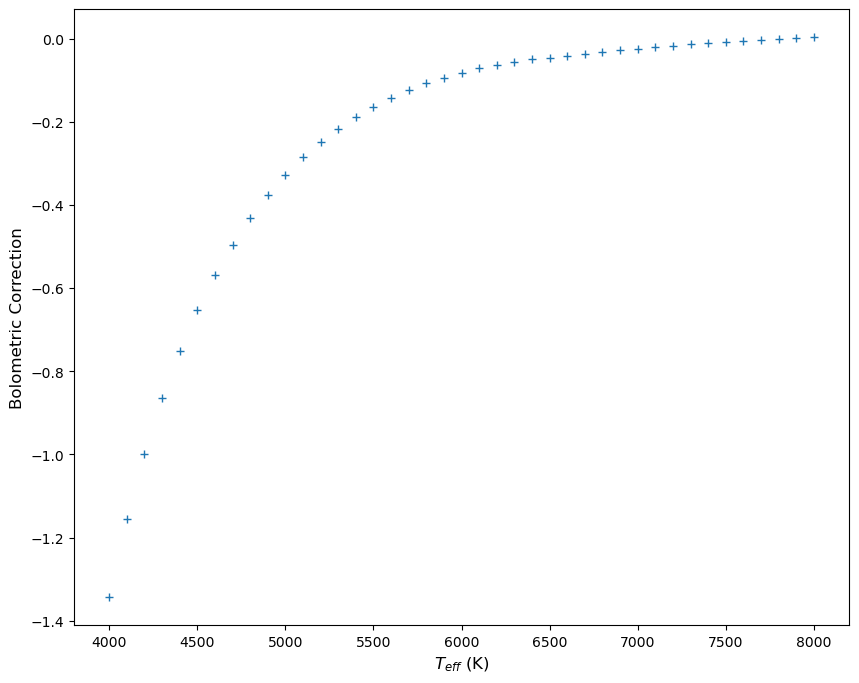

In [67]:
fig, axs = plt.subplots(figsize=(10,8))
axs.plot(BC_data["# Teff"],BC_data["BC"], marker='+', linestyle='None')
axs.set_xlabel(r'$T_{eff}$ (K)',fontsize=12)
axs.set_ylabel('Bolometric Correction',fontsize=12)

Now, we perform spline interpolation using the $\mathrm{splrep}$ function from interpolate

In [68]:
#Interpolation
from scipy import interpolate

In [69]:
"""
This function returns a 3-tuple (t,c,k) containing the knot-points t,
the coefficients, c and the order k of the spline
the first two arguments provide the x and y components of the curve
"""

tck = interpolate.splrep(T_eff, BC, s=0) 

Teff_new = np.linspace(np.min(T_eff),np.max(T_eff),len(abs_mag_Hp))
BC_new = interpolate.splev(Teff_new,tck,der=0)

Text(0, 0.5, 'Bolometric Correction as a function of $T_{eff} with spline interpolation$')

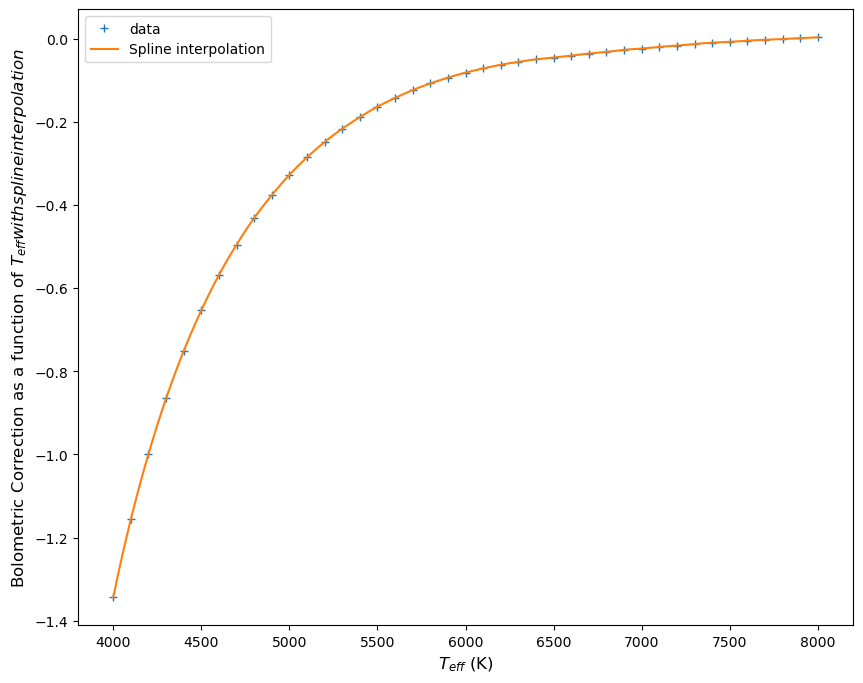

In [70]:
fig, axs = plt.subplots(figsize=(10,8))
axs.plot(T_eff,BC,'+',linestyle='None',label='data')
axs.plot(Teff_new,BC_new,label='Spline interpolation')
axs.legend()
axs.set_xlabel(r'$T_{eff}$ (K)',fontsize=12)
axs.set_ylabel(r'Bolometric Correction as a function of $T_{eff} with spline interpolation$',fontsize=12)

Now, once the interpolation has been done, we can estimate the luminosity with the function:
$$
-2.5 \ \mathrm{log_{10}} \Big( \frac{L}{L_\odot} \Big) = M_\mathrm{Hp} + BC_\mathrm{Hp}(T_\mathrm{eff}) - M_\odot
$$


We can rearrange terms and obtain the equation for luminosity:
$$
L = L_\odot 10^{\frac{-(M_\mathrm{Hp}+BC_\mathrm{Hp}(T_\mathrm{eff})-M_\odot)}{2.5}}
$$

which we implement below.

In [71]:
def f_luminosity(M_Hp,BC_Hp):
    "Gives the luminosity in solar luminosities"
    L_sun = 3.828e26 #W
    M_sun = 4.74 #sun's magnitude in the V band
    L = np.power(10,-1*(M_Hp+BC_Hp-M_sun)/2.5)
    return L

Now, we calculate the luminosity with the data that we had from the catalogue and the bolometric correction obtained from the interpolation

In [72]:
Lum = f_luminosity(abs_mag_Hp, BC_new)

Text(0, 0.5, 'Luminosity ($L_\\odot$)')

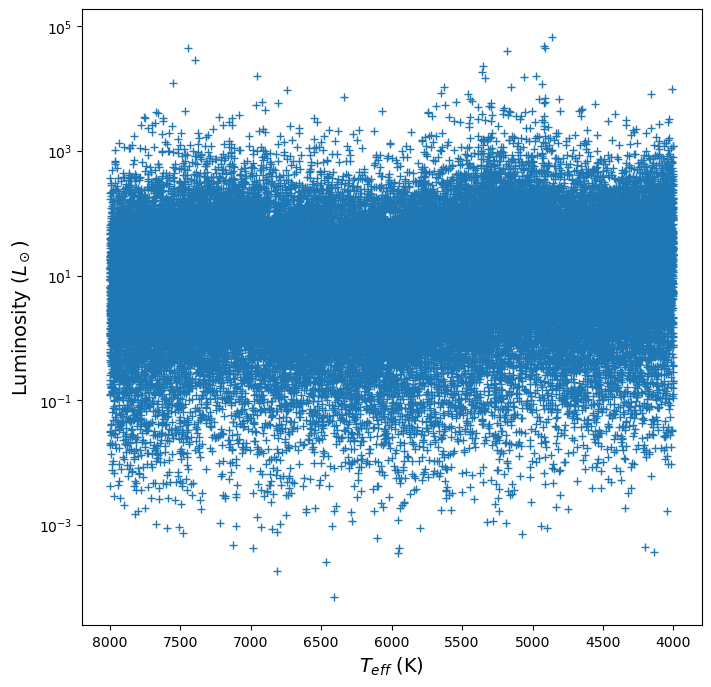

In [77]:
fig, axs = plt.subplots(figsize=(8,8))
axs.scatter(Teff_new, Lum,marker='+',linewidths=1)
axs.invert_xaxis()
axs.set_yscale('log')
#axs.set_ylim([0.01,1e3])
axs.set_xlabel(r'$T_{eff}$ (K)',fontsize=14)
axs.set_ylabel(r'Luminosity ($L_\odot$)',fontsize=14)

From the plot, it can be noticed that after applying the bolometric correction, the features in the HR diagram are not longer visible, this could be due to an error in the spline interpolation. In this approach, all values between two data points for the effective temperature were found using spline interpolation, however, it is not clear if the temperatures obtained from this data set correspond to the actual temperature of the stars in the Hipparos' catalogue. In this analysis this assumption was made but as can be seen from the figure, other assumptions must be made to obtain better results.  